In [1]:
import numpy as np
from joblib import Parallel, delayed
import csv
from cqs.object import Instance
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.circuit.random import random_circuit
import qiskit.qasm3 as qasm3
from instances_b.reader_b import read_csv_b
from transpiler.transpile import transpile_circuit
from examples.benchmark.cqs_simulation import main_prober, main_solver
from qiskit.quantum_info import Operator
from tqdm import tqdm
from cqs.local.calculation import __estimate_V_dagger_V,__estimate_q,__reshape_to_Q_r
from cqs.optimization import solve_combination_parameters
from matplotlib import pyplot as plt
import time
import torch
from cqs.local.calculation import calculate_Q_r
import numpy as np
import pandas as pd
def normalize_quantum_state(vec):
    norm=np.sqrt(np.abs(vec.T.conjugate()@vec))
    return vec/norm

def __num_to_pauli_list(num_list):
    paulis = ['I', 'X', 'Y', 'Z']
    pauli_list = [paulis[int(i)] for i in num_list]
    return pauli_list

def __add_Pauli_gate(qc, which_qubit, which_gate):
    if which_gate == 0:
        qc.id(which_qubit)
    elif which_gate == 1:
        qc.x(which_qubit)
    elif which_gate == 2:
        qc.y(which_qubit)
    elif which_gate == 3:
        qc.z(which_qubit)
    else:
        return ValueError("Not supported Pauli gate type.")

def __num_to_pauli_circuit(num_list):
    n = len(num_list)
    num_list = [int(i) for i in num_list]
    qr = QuantumRegister(n, 'q')
    qc = QuantumCircuit(qr)
    for i in range(n):
        __add_Pauli_gate(qc, i, num_list[i])
    return qc

def create_random_circuit_in_native_gate(n, d):
    ub = random_circuit(num_qubits=n,max_operands=2, depth=d, measure=False)
    # ub = transpile_circuit(ub, device='Aria', optimization_level=2)
    return ub

In [2]:
with open('3_qubit_data_generation_matrix_A.csv', 'r', newline='') as csvfile:
    data_b = read_csv_b(3)
    reader = csv.reader(csvfile, delimiter=' ', quotechar='|')
    for i, row in enumerate(reader):
        if 2 > i > 0:
            row_clean = [j for j in ''.join(row).split('"') if j != ',']
            nLc = row_clean[0].split(',')
            n = int(nLc[0])
            print("qubit number is:", n)
            L = int(nLc[1])
            print("term number is:", L)
            kappa = float(nLc[2])
            print('condition number is', kappa)
            pauli_strings = [__num_to_pauli_list(l) for l in eval(row_clean[1])]
            print('Pauli strings are:', pauli_strings)
            pauli_circuits = [__num_to_pauli_circuit(l) for l in eval(row_clean[1])]
            coeffs = [float(i) for i in eval(row_clean[2])]
            print('coefficients are:', coeffs)
            print()

            # circuit depth d
            d = 3
            ub = qasm3.loads(data_b.iloc[i].qasm)
            print('Ub is given by:', data_b.iloc[i].b)
            print(ub)

            # generate instance
            instance = Instance(n, L, kappa)
            instance.generate(given_coeffs=coeffs, given_unitaries=pauli_circuits, given_ub=ub)
            Itr, LOSS, ansatz_tree = main_prober(instance, backend='qiskit-noiseless',ITR=None,
                                    shots=0, optimization_level=2,
                                    noise_level_two_qubit=0, noise_level_one_qubit=0, readout_error=0)
            print(Itr)
            print(LOSS)
            print('ANsatz tree contains:')
            # for qc in ansatz_tree:
            #     print(qc)
ansatz_tree=[ansatz_tree[i] for i in range(len(ansatz_tree)-1)]

Resolved file path: C:\Users\Nikita\PycharmProjects\CQS_singapore\instances_b\3_b_random_circuits.csv
Reading file: C:\Users\Nikita\PycharmProjects\CQS_singapore\instances_b\3_b_random_circuits.csv
qubit number is: 3
term number is: 3
condition number is 3.5456037521362305
Pauli strings are: [['Y', 'Z', 'Y'], ['I', 'Y', 'Y'], ['X', 'Y', 'I']]
coefficients are: [-1.01, 1.17, 2.76]

Ub is given by: [(0.7071067811865475+0j), 0j, 0j, 0j, (-0.6099094210942649+0.357785547584665j), 0j, 0j, 0j]
                                           
q_0: ──────────X───────────■───────■───────
               │           │ ┌─────┴──────┐
q_1: ──────────X───────────■─┤ Rz(4.3897) ├
     ┌───────────────────┐   └────────────┘
q_2: ┤ U2(2.6111,5.8783) ├─────────────────
     └───────────────────┘                 


Hadamard tests q Progress: 100%|██████████| 3/3 [00:00<00:00, 15.79it/s]
C:\Users\Nikita\PycharmProjects\CQS_singapore\cqs\optimization.py:91: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\native\TensorShape.cpp:3729.)
  return torch.abs(0.5*torch.matmul(x.T, torch.matmul(Q, x)) + torch.matmul(r.T, x) + 1)


loss: 1.0
combination parameters are: [(8.87592818012649e-19+2.176216515096441e-42j)]


Hadamard tests q Progress: 100%|██████████| 6/6 [00:00<00:00, 15.84it/s]


loss: 0.23874246416147027
combination parameters are: [(2.0200095906450677e-18+1.224068901491177e-17j), (0.2758179008960724-3.0621905330635414e-17j)]


Hadamard tests q Progress: 100%|██████████| 9/9 [00:00<00:00, 15.90it/s]


loss: 0.04036166897399318
combination parameters are: [(1.0263173139899624e-17-0.0944686084985733j), (0.27581796050071716-4.234503322653704e-17j), (5.660840962253187e-17-0.16955620050430298j)]


Hadamard tests q Progress: 100%|██████████| 12/12 [00:00<00:00, 15.27it/s]


loss: 6.769973071030222e-08
combination parameters are: [(1.396838559158494e-17-0.09446855634450912j), (0.31842899322509766-3.953982885007576e-17j), (6.302551137859575e-17-0.16955609619617462j), (0.07648006081581116+2.0670917598538816e-17j)]
[1, 2, 3, 4]
[1.0, 0.23874246416147027, 0.04036166897399318, 6.769973071030222e-08]
ANsatz tree contains:


# NOISELESS

In [3]:
V_dagger_V=__estimate_V_dagger_V(instance, ansatz_tree,loss_type=None, backend='qiskit-noiseless', ITR=None, shots=0, optimization_level=2)
q=__estimate_q(instance, ansatz_tree, backend='qiskit-noiseless', ITR=None, shots=0, optimization_level=2)
losses=[]
for depth in tqdm(range(len(ansatz_tree))):
    Q, r = __reshape_to_Q_r(V_dagger_V[:depth+1:,:depth+1:], q[:depth+1:])
    loss, _ = solve_combination_parameters(Q, r, which_opt='ADAM')
    losses+=[loss]

100%|██████████| 4/4 [00:09<00:00,  2.38s/it]


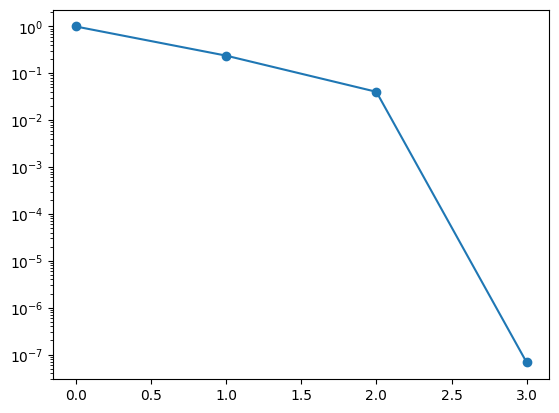

In [4]:
plt.plot(losses,"-o")
plt.yscale('log')

# Noisy

In [5]:
Q_true, r_true = calculate_Q_r(instance, ansatz_tree, backend='qiskit-noiseless', ITR=None,
                               shots=0, optimization_level=2,
                               noise_level_two_qubit=0, noise_level_one_qubit=0, readout_error=0)
def find_true_loss_function(alphas,Q=Q_true,r=r_true):
    x=np.vstack((np.real(alphas),np.imag(alphas))).reshape(-1,1)
    depth=len(alphas)-1
    # Define the four sectors (quadrants)
    q1 = Q[:depth+1, :depth+1]
    q2 = Q[:depth+1, 4:4+depth+1]
    q3 = Q[4:4+depth+1, :depth+1]
    q4 = Q[4:4+depth+1, 4:4+depth+1]
    
    # Stack them back together
    top = np.hstack((q1, q2))
    bottom = np.hstack((q3, q4))
    Q1 = np.vstack((top, bottom))
    
    r1=r[:depth+1]
    r2=r[4:4+depth+1]
    
    r1=np.vstack((r1,r2)).reshape(-1,1)
    xt=torch.Tensor(x)
    Qt=torch.Tensor(Q1)*2
    rt=torch.Tensor(r1)*(-2)
    return (0.5*torch.matmul(xt.T, torch.matmul(Qt, xt))+ torch.matmul(rt.T, xt) + 1).item()

Hadamard tests q Progress: 100%|██████████| 12/12 [00:01<00:00, 10.64it/s]


Hadamard tests V_dagger_V Progress:   1%|          | 1/90 [00:00<00:20,  4.42it/s]

IsingZZ Wires([2, 1]) хуй
IsingZZ Wires([2, 1]) хуй
IsingZZ Wires([0, 2]) хуй
IsingZZ Wires([0, 1]) хуй
IsingZZ Wires([0, 3]) хуй
IsingZZ Wires([0, 2]) хуй
IsingZZ Wires([0, 1]) хуй
IsingZZ Wires([0, 3]) хуй
IsingZZ Wires([2, 1]) хуй
IsingZZ Wires([2, 1]) хуй
IsingZZ Wires([0, 2]) хуй
IsingZZ Wires([0, 1]) хуй
IsingZZ Wires([0, 3]) хуй
IsingZZ Wires([0, 2]) хуй
IsingZZ Wires([0, 1]) хуй
IsingZZ Wires([0, 3]) хуй
IsingZZ Wires([2, 1]) хуй
IsingZZ Wires([2, 1]) хуй
IsingZZ Wires([0, 2]) хуй
IsingZZ Wires([0, 1]) хуй
IsingZZ Wires([0, 3]) хуй
IsingZZ Wires([0, 1]) хуй
IsingZZ Wires([0, 3]) хуй


Hadamard tests V_dagger_V Progress:   2%|▏         | 2/90 [00:00<00:18,  4.78it/s]

IsingZZ Wires([2, 1]) хуй
IsingZZ Wires([2, 1]) хуй
IsingZZ Wires([0, 2]) хуй
IsingZZ Wires([0, 1]) хуй
IsingZZ Wires([0, 3]) хуй
IsingZZ Wires([0, 1]) хуй
IsingZZ Wires([0, 3]) хуй
IsingZZ Wires([2, 1]) хуй
IsingZZ Wires([2, 1]) хуй
IsingZZ Wires([0, 2]) хуй
IsingZZ Wires([0, 1]) хуй
IsingZZ Wires([0, 3]) хуй
IsingZZ Wires([0, 2]) хуй
IsingZZ Wires([0, 1]) хуй
IsingZZ Wires([2, 1]) хуй
IsingZZ Wires([2, 1]) хуй
IsingZZ Wires([0, 2]) хуй
IsingZZ Wires([0, 1]) хуй
IsingZZ Wires([0, 3]) хуй
IsingZZ Wires([0, 2]) хуй
IsingZZ Wires([0, 1]) хуй


Hadamard tests V_dagger_V Progress:   4%|▍         | 4/90 [00:00<00:17,  4.97it/s]

IsingZZ Wires([2, 1]) хуй
IsingZZ Wires([2, 1]) хуй
IsingZZ Wires([0, 1]) хуй
IsingZZ Wires([0, 3]) хуй
IsingZZ Wires([0, 2]) хуй
IsingZZ Wires([0, 1]) хуй
IsingZZ Wires([0, 3]) хуй
IsingZZ Wires([2, 1]) хуй
IsingZZ Wires([2, 1]) хуй
IsingZZ Wires([0, 1]) хуй
IsingZZ Wires([0, 3]) хуй
IsingZZ Wires([0, 2]) хуй
IsingZZ Wires([0, 1]) хуй
IsingZZ Wires([0, 3]) хуй
IsingZZ Wires([2, 1]) хуй
IsingZZ Wires([2, 1]) хуй
IsingZZ Wires([0, 1]) хуй
IsingZZ Wires([0, 3]) хуй
IsingZZ Wires([0, 1]) хуй
IsingZZ Wires([0, 3]) хуй


Hadamard tests V_dagger_V Progress:   6%|▌         | 5/90 [00:01<00:17,  5.00it/s]

IsingZZ Wires([2, 1]) хуй
IsingZZ Wires([2, 1]) хуй
IsingZZ Wires([0, 1]) хуй
IsingZZ Wires([0, 3]) хуй
IsingZZ Wires([0, 1]) хуй
IsingZZ Wires([0, 3]) хуй
IsingZZ Wires([2, 1]) хуй
IsingZZ Wires([2, 1]) хуй
IsingZZ Wires([0, 1]) хуй
IsingZZ Wires([0, 3]) хуй
IsingZZ Wires([0, 2]) хуй
IsingZZ Wires([0, 1]) хуй


Hadamard tests V_dagger_V Progress:   7%|▋         | 6/90 [00:01<00:17,  4.72it/s]

IsingZZ Wires([2, 1]) хуй
IsingZZ Wires([2, 1]) хуй
IsingZZ Wires([0, 1]) хуй
IsingZZ Wires([0, 3]) хуй
IsingZZ Wires([0, 2]) хуй
IsingZZ Wires([0, 1]) хуй
IsingZZ Wires([2, 1]) хуй
IsingZZ Wires([2, 1]) хуй
IsingZZ Wires([0, 2]) хуй
IsingZZ Wires([0, 1]) хуй
IsingZZ Wires([0, 2]) хуй
IsingZZ Wires([0, 1]) хуй
IsingZZ Wires([0, 3]) хуй
IsingZZ Wires([2, 1]) хуй
IsingZZ Wires([2, 1]) хуй
IsingZZ Wires([0, 2]) хуй
IsingZZ Wires([0, 1]) хуй
IsingZZ Wires([0, 2]) хуй
IsingZZ Wires([0, 1]) хуй
IsingZZ Wires([0, 3]) хуй


Hadamard tests V_dagger_V Progress:   9%|▉         | 8/90 [00:01<00:17,  4.58it/s]

IsingZZ Wires([2, 1]) хуй
IsingZZ Wires([2, 1]) хуй
IsingZZ Wires([0, 2]) хуй
IsingZZ Wires([0, 1]) хуй
IsingZZ Wires([0, 1]) хуй
IsingZZ Wires([0, 3]) хуй
IsingZZ Wires([2, 1]) хуй
IsingZZ Wires([2, 1]) хуй
IsingZZ Wires([0, 2]) хуй
IsingZZ Wires([0, 1]) хуй
IsingZZ Wires([0, 1]) хуй
IsingZZ Wires([0, 3]) хуй
IsingZZ Wires([2, 1]) хуй
IsingZZ Wires([2, 1]) хуй
IsingZZ Wires([0, 2]) хуй
IsingZZ Wires([0, 1]) хуй
IsingZZ Wires([0, 2]) хуй
IsingZZ Wires([0, 1]) хуй


Hadamard tests V_dagger_V Progress:  10%|█         | 9/90 [00:02<00:34,  2.35it/s]

IsingZZ Wires([2, 1]) хуй
IsingZZ Wires([2, 1]) хуй
IsingZZ Wires([0, 2]) хуй
IsingZZ Wires([0, 1]) хуй
IsingZZ Wires([0, 2]) хуй
IsingZZ Wires([0, 1]) хуй
IsingZZ Wires([2, 1]) хуй
IsingZZ Wires([2, 1]) хуй
IsingZZ Wires([0, 2]) хуй
IsingZZ Wires([0, 1]) хуй
IsingZZ Wires([0, 3]) хуй
IsingZZ Wires([0, 2]) хуй
IsingZZ Wires([0, 2]) хуй
IsingZZ Wires([0, 2]) хуй
IsingZZ Wires([0, 1]) хуй
IsingZZ Wires([0, 3]) хуй
IsingZZ Wires([2, 1]) хуй
IsingZZ Wires([2, 1]) хуй
IsingZZ Wires([0, 2]) хуй
IsingZZ Wires([0, 1]) хуй
IsingZZ Wires([0, 3]) хуй
IsingZZ Wires([0, 2]) хуй
IsingZZ Wires([0, 2]) хуй
IsingZZ Wires([0, 2]) хуй
IsingZZ Wires([0, 1]) хуй
IsingZZ Wires([0, 3]) хуй


Hadamard tests V_dagger_V Progress:  12%|█▏        | 11/90 [00:03<00:25,  3.14it/s]

IsingZZ Wires([2, 1]) хуй
IsingZZ Wires([2, 1]) хуй
IsingZZ Wires([0, 2]) хуй
IsingZZ Wires([0, 1]) хуй
IsingZZ Wires([0, 3]) хуй
IsingZZ Wires([0, 2]) хуй
IsingZZ Wires([0, 3]) хуй
IsingZZ Wires([2, 1]) хуй
IsingZZ Wires([2, 1]) хуй
IsingZZ Wires([0, 2]) хуй
IsingZZ Wires([0, 1]) хуй
IsingZZ Wires([0, 3]) хуй
IsingZZ Wires([0, 2]) хуй
IsingZZ Wires([0, 3]) хуй


Hadamard tests V_dagger_V Progress:  13%|█▎        | 12/90 [00:03<00:22,  3.51it/s]

IsingZZ Wires([2, 1]) хуй
IsingZZ Wires([2, 1]) хуй
IsingZZ Wires([0, 2]) хуй
IsingZZ Wires([0, 1]) хуй
IsingZZ Wires([0, 3]) хуй
IsingZZ Wires([2, 1]) хуй
IsingZZ Wires([2, 1]) хуй
IsingZZ Wires([0, 2]) хуй
IsingZZ Wires([0, 1]) хуй
IsingZZ Wires([0, 3]) хуй
IsingZZ Wires([2, 1]) хуй
IsingZZ Wires([2, 1]) хуй
IsingZZ Wires([0, 1]) хуй
IsingZZ Wires([0, 3]) хуй
IsingZZ Wires([0, 2]) хуй
IsingZZ Wires([0, 2]) хуй
IsingZZ Wires([0, 2]) хуй
IsingZZ Wires([0, 1]) хуй
IsingZZ Wires([0, 3]) хуй


Hadamard tests V_dagger_V Progress:  14%|█▍        | 13/90 [00:03<00:20,  3.74it/s]

IsingZZ Wires([2, 1]) хуй
IsingZZ Wires([2, 1]) хуй
IsingZZ Wires([0, 1]) хуй
IsingZZ Wires([0, 3]) хуй
IsingZZ Wires([0, 2]) хуй
IsingZZ Wires([0, 2]) хуй
IsingZZ Wires([0, 2]) хуй
IsingZZ Wires([0, 1]) хуй
IsingZZ Wires([0, 3]) хуй
IsingZZ Wires([2, 1]) хуй
IsingZZ Wires([2, 1]) хуй
IsingZZ Wires([0, 1]) хуй
IsingZZ Wires([0, 3]) хуй
IsingZZ Wires([0, 2]) хуй
IsingZZ Wires([0, 3]) хуй
IsingZZ Wires([2, 1]) хуй
IsingZZ Wires([2, 1]) хуй
IsingZZ Wires([0, 1]) хуй
IsingZZ Wires([0, 3]) хуй
IsingZZ Wires([0, 2]) хуй
IsingZZ Wires([0, 3]) хуй


Hadamard tests V_dagger_V Progress:  17%|█▋        | 15/90 [00:03<00:17,  4.38it/s]

IsingZZ Wires([2, 1]) хуй
IsingZZ Wires([2, 1]) хуй
IsingZZ Wires([0, 1]) хуй
IsingZZ Wires([0, 3]) хуй
IsingZZ Wires([2, 1]) хуй
IsingZZ Wires([2, 1]) хуй
IsingZZ Wires([0, 1]) хуй
IsingZZ Wires([0, 3]) хуй
IsingZZ Wires([2, 1]) хуй
IsingZZ Wires([2, 1]) хуй
IsingZZ Wires([0, 2]) хуй
IsingZZ Wires([0, 1]) хуй
IsingZZ Wires([0, 2]) хуй
IsingZZ Wires([0, 2]) хуй
IsingZZ Wires([0, 2]) хуй
IsingZZ Wires([0, 1]) хуй
IsingZZ Wires([0, 3]) хуй


Hadamard tests V_dagger_V Progress:  18%|█▊        | 16/90 [00:04<00:16,  4.50it/s]

IsingZZ Wires([2, 1]) хуй
IsingZZ Wires([2, 1]) хуй
IsingZZ Wires([0, 2]) хуй
IsingZZ Wires([0, 1]) хуй
IsingZZ Wires([0, 2]) хуй
IsingZZ Wires([0, 2]) хуй
IsingZZ Wires([0, 2]) хуй
IsingZZ Wires([0, 1]) хуй
IsingZZ Wires([0, 3]) хуй
IsingZZ Wires([2, 1]) хуй
IsingZZ Wires([2, 1]) хуй
IsingZZ Wires([0, 2]) хуй
IsingZZ Wires([0, 1]) хуй
IsingZZ Wires([0, 2]) хуй
IsingZZ Wires([0, 3]) хуй
IsingZZ Wires([2, 1]) хуй
IsingZZ Wires([2, 1]) хуй
IsingZZ Wires([0, 2]) хуй
IsingZZ Wires([0, 1]) хуй
IsingZZ Wires([0, 2]) хуй
IsingZZ Wires([0, 3]) хуй


Hadamard tests V_dagger_V Progress:  20%|██        | 18/90 [00:04<00:15,  4.52it/s]

IsingZZ Wires([2, 1]) хуй
IsingZZ Wires([2, 1]) хуй
IsingZZ Wires([0, 2]) хуй
IsingZZ Wires([0, 1]) хуй
IsingZZ Wires([2, 1]) хуй
IsingZZ Wires([2, 1]) хуй
IsingZZ Wires([0, 2]) хуй
IsingZZ Wires([0, 1]) хуй
IsingZZ Wires([2, 1]) хуй
IsingZZ Wires([2, 1]) хуй
IsingZZ Wires([0, 2]) хуй
IsingZZ Wires([0, 1]) хуй
IsingZZ Wires([0, 3]) хуй
IsingZZ Wires([0, 2]) хуй
IsingZZ Wires([0, 2]) хуй
IsingZZ Wires([0, 2]) хуй
IsingZZ Wires([0, 2]) хуй
IsingZZ Wires([0, 2]) хуй
IsingZZ Wires([0, 1]) хуй


Hadamard tests V_dagger_V Progress:  21%|██        | 19/90 [00:04<00:16,  4.19it/s]

IsingZZ Wires([2, 1]) хуй
IsingZZ Wires([2, 1]) хуй
IsingZZ Wires([0, 2]) хуй
IsingZZ Wires([0, 1]) хуй
IsingZZ Wires([0, 3]) хуй
IsingZZ Wires([0, 2]) хуй
IsingZZ Wires([0, 2]) хуй
IsingZZ Wires([0, 2]) хуй
IsingZZ Wires([0, 2]) хуй
IsingZZ Wires([0, 2]) хуй
IsingZZ Wires([0, 1]) хуй
IsingZZ Wires([2, 1]) хуй
IsingZZ Wires([2, 1]) хуй
IsingZZ Wires([0, 2]) хуй
IsingZZ Wires([0, 1]) хуй
IsingZZ Wires([0, 3]) хуй
IsingZZ Wires([0, 2]) хуй
IsingZZ Wires([0, 1]) хуй


Hadamard tests V_dagger_V Progress:  22%|██▏       | 20/90 [00:05<00:17,  3.95it/s]

IsingZZ Wires([2, 1]) хуй
IsingZZ Wires([2, 1]) хуй
IsingZZ Wires([0, 2]) хуй
IsingZZ Wires([0, 1]) хуй
IsingZZ Wires([0, 3]) хуй
IsingZZ Wires([0, 2]) хуй
IsingZZ Wires([0, 1]) хуй
IsingZZ Wires([2, 1]) хуй
IsingZZ Wires([2, 1]) хуй
IsingZZ Wires([0, 2]) хуй
IsingZZ Wires([0, 1]) хуй
IsingZZ Wires([0, 3]) хуй
IsingZZ Wires([0, 2]) хуй
IsingZZ Wires([0, 1]) хуй
IsingZZ Wires([0, 3]) хуй


Hadamard tests V_dagger_V Progress:  23%|██▎       | 21/90 [00:05<00:18,  3.82it/s]

IsingZZ Wires([2, 1]) хуй
IsingZZ Wires([2, 1]) хуй
IsingZZ Wires([0, 2]) хуй
IsingZZ Wires([0, 1]) хуй
IsingZZ Wires([0, 3]) хуй
IsingZZ Wires([0, 2]) хуй
IsingZZ Wires([0, 1]) хуй
IsingZZ Wires([0, 3]) хуй
IsingZZ Wires([2, 1]) хуй
IsingZZ Wires([2, 1]) хуй
IsingZZ Wires([0, 1]) хуй
IsingZZ Wires([0, 3]) хуй
IsingZZ Wires([0, 2]) хуй
IsingZZ Wires([0, 2]) хуй
IsingZZ Wires([0, 2]) хуй
IsingZZ Wires([0, 2]) хуй
IsingZZ Wires([0, 2]) хуй
IsingZZ Wires([0, 1]) хуй


Hadamard tests V_dagger_V Progress:  24%|██▍       | 22/90 [00:05<00:19,  3.44it/s]

IsingZZ Wires([2, 1]) хуй
IsingZZ Wires([2, 1]) хуй
IsingZZ Wires([0, 1]) хуй
IsingZZ Wires([0, 3]) хуй
IsingZZ Wires([0, 2]) хуй
IsingZZ Wires([0, 2]) хуй
IsingZZ Wires([0, 2]) хуй
IsingZZ Wires([0, 2]) хуй
IsingZZ Wires([0, 2]) хуй
IsingZZ Wires([0, 1]) хуй
IsingZZ Wires([2, 1]) хуй
IsingZZ Wires([2, 1]) хуй
IsingZZ Wires([0, 1]) хуй
IsingZZ Wires([0, 3]) хуй
IsingZZ Wires([0, 2]) хуй
IsingZZ Wires([0, 1]) хуй


Hadamard tests V_dagger_V Progress:  26%|██▌       | 23/90 [00:06<00:20,  3.24it/s]

IsingZZ Wires([2, 1]) хуй
IsingZZ Wires([2, 1]) хуй
IsingZZ Wires([0, 1]) хуй
IsingZZ Wires([0, 3]) хуй
IsingZZ Wires([0, 2]) хуй
IsingZZ Wires([0, 1]) хуй
IsingZZ Wires([2, 1]) хуй
IsingZZ Wires([2, 1]) хуй
IsingZZ Wires([0, 1]) хуй
IsingZZ Wires([0, 3]) хуй
IsingZZ Wires([0, 2]) хуй
IsingZZ Wires([0, 1]) хуй
IsingZZ Wires([0, 3]) хуй


Hadamard tests V_dagger_V Progress:  27%|██▋       | 24/90 [00:06<00:20,  3.15it/s]

IsingZZ Wires([2, 1]) хуй
IsingZZ Wires([2, 1]) хуй
IsingZZ Wires([0, 1]) хуй
IsingZZ Wires([0, 3]) хуй
IsingZZ Wires([0, 2]) хуй
IsingZZ Wires([0, 1]) хуй
IsingZZ Wires([0, 3]) хуй
IsingZZ Wires([2, 1]) хуй
IsingZZ Wires([2, 1]) хуй
IsingZZ Wires([0, 2]) хуй
IsingZZ Wires([0, 1]) хуй
IsingZZ Wires([0, 2]) хуй
IsingZZ Wires([0, 2]) хуй
IsingZZ Wires([0, 2]) хуй
IsingZZ Wires([0, 2]) хуй
IsingZZ Wires([0, 2]) хуй
IsingZZ Wires([0, 1]) хуй


Hadamard tests V_dagger_V Progress:  28%|██▊       | 25/90 [00:06<00:22,  2.95it/s]

IsingZZ Wires([2, 1]) хуй
IsingZZ Wires([2, 1]) хуй
IsingZZ Wires([0, 2]) хуй
IsingZZ Wires([0, 1]) хуй
IsingZZ Wires([0, 2]) хуй
IsingZZ Wires([0, 2]) хуй
IsingZZ Wires([0, 2]) хуй
IsingZZ Wires([0, 2]) хуй
IsingZZ Wires([0, 2]) хуй
IsingZZ Wires([0, 1]) хуй
IsingZZ Wires([2, 1]) хуй
IsingZZ Wires([2, 1]) хуй
IsingZZ Wires([0, 2]) хуй
IsingZZ Wires([0, 1]) хуй
IsingZZ Wires([0, 2]) хуй
IsingZZ Wires([0, 1]) хуй


Hadamard tests V_dagger_V Progress:  29%|██▉       | 26/90 [00:07<00:19,  3.27it/s]

IsingZZ Wires([2, 1]) хуй
IsingZZ Wires([2, 1]) хуй
IsingZZ Wires([0, 2]) хуй
IsingZZ Wires([0, 1]) хуй
IsingZZ Wires([0, 2]) хуй
IsingZZ Wires([0, 1]) хуй
IsingZZ Wires([2, 1]) хуй
IsingZZ Wires([2, 1]) хуй
IsingZZ Wires([0, 2]) хуй
IsingZZ Wires([0, 1]) хуй
IsingZZ Wires([0, 2]) хуй
IsingZZ Wires([0, 1]) хуй
IsingZZ Wires([0, 3]) хуй


Hadamard tests V_dagger_V Progress:  30%|███       | 27/90 [00:07<00:19,  3.20it/s]

IsingZZ Wires([2, 1]) хуй
IsingZZ Wires([2, 1]) хуй
IsingZZ Wires([0, 2]) хуй
IsingZZ Wires([0, 1]) хуй
IsingZZ Wires([0, 2]) хуй
IsingZZ Wires([0, 1]) хуй
IsingZZ Wires([0, 3]) хуй
IsingZZ Wires([2, 1]) хуй
IsingZZ Wires([2, 1]) хуй
IsingZZ Wires([0, 2]) хуй
IsingZZ Wires([0, 1]) хуй
IsingZZ Wires([0, 3]) хуй


Hadamard tests V_dagger_V Progress:  31%|███       | 28/90 [00:07<00:18,  3.44it/s]

IsingZZ Wires([2, 1]) хуй
IsingZZ Wires([2, 1]) хуй
IsingZZ Wires([0, 2]) хуй
IsingZZ Wires([0, 1]) хуй
IsingZZ Wires([0, 3]) хуй
IsingZZ Wires([2, 1]) хуй
IsingZZ Wires([2, 1]) хуй
IsingZZ Wires([0, 2]) хуй
IsingZZ Wires([0, 1]) хуй
IsingZZ Wires([0, 3]) хуй
IsingZZ Wires([0, 2]) хуй
IsingZZ Wires([0, 1]) хуй
IsingZZ Wires([2, 1]) хуй
IsingZZ Wires([2, 1]) хуй
IsingZZ Wires([0, 2]) хуй
IsingZZ Wires([0, 1]) хуй
IsingZZ Wires([0, 3]) хуй
IsingZZ Wires([0, 2]) хуй
IsingZZ Wires([0, 1]) хуй


Hadamard tests V_dagger_V Progress:  33%|███▎      | 30/90 [00:08<00:16,  3.67it/s]

IsingZZ Wires([2, 1]) хуй
IsingZZ Wires([2, 1]) хуй
IsingZZ Wires([0, 2]) хуй
IsingZZ Wires([0, 1]) хуй
IsingZZ Wires([0, 3]) хуй
IsingZZ Wires([0, 2]) хуй
IsingZZ Wires([0, 1]) хуй
IsingZZ Wires([0, 3]) хуй
IsingZZ Wires([2, 1]) хуй
IsingZZ Wires([2, 1]) хуй
IsingZZ Wires([0, 2]) хуй
IsingZZ Wires([0, 1]) хуй
IsingZZ Wires([0, 3]) хуй
IsingZZ Wires([0, 2]) хуй
IsingZZ Wires([0, 1]) хуй
IsingZZ Wires([0, 3]) хуй


Hadamard tests V_dagger_V Progress:  34%|███▍      | 31/90 [00:08<00:15,  3.85it/s]

IsingZZ Wires([2, 1]) хуй
IsingZZ Wires([2, 1]) хуй
IsingZZ Wires([0, 1]) хуй
IsingZZ Wires([0, 3]) хуй
IsingZZ Wires([2, 1]) хуй
IsingZZ Wires([2, 1]) хуй
IsingZZ Wires([0, 1]) хуй
IsingZZ Wires([0, 3]) хуй
IsingZZ Wires([2, 1]) хуй
IsingZZ Wires([2, 1]) хуй
IsingZZ Wires([0, 1]) хуй
IsingZZ Wires([0, 3]) хуй
IsingZZ Wires([0, 2]) хуй
IsingZZ Wires([0, 1]) хуй


Hadamard tests V_dagger_V Progress:  36%|███▌      | 32/90 [00:08<00:14,  3.95it/s]

IsingZZ Wires([2, 1]) хуй
IsingZZ Wires([2, 1]) хуй
IsingZZ Wires([0, 1]) хуй
IsingZZ Wires([0, 3]) хуй
IsingZZ Wires([0, 2]) хуй
IsingZZ Wires([0, 1]) хуй
IsingZZ Wires([2, 1]) хуй
IsingZZ Wires([2, 1]) хуй
IsingZZ Wires([0, 1]) хуй
IsingZZ Wires([0, 3]) хуй
IsingZZ Wires([0, 2]) хуй
IsingZZ Wires([0, 1]) хуй
IsingZZ Wires([0, 3]) хуй


Hadamard tests V_dagger_V Progress:  37%|███▋      | 33/90 [00:08<00:14,  4.04it/s]

IsingZZ Wires([2, 1]) хуй
IsingZZ Wires([2, 1]) хуй
IsingZZ Wires([0, 1]) хуй
IsingZZ Wires([0, 3]) хуй
IsingZZ Wires([0, 2]) хуй
IsingZZ Wires([0, 1]) хуй
IsingZZ Wires([0, 3]) хуй
IsingZZ Wires([2, 1]) хуй
IsingZZ Wires([2, 1]) хуй
IsingZZ Wires([0, 2]) хуй
IsingZZ Wires([0, 1]) хуй


Hadamard tests V_dagger_V Progress:  38%|███▊      | 34/90 [00:09<00:14,  3.86it/s]

IsingZZ Wires([2, 1]) хуй
IsingZZ Wires([2, 1]) хуй
IsingZZ Wires([0, 2]) хуй
IsingZZ Wires([0, 1]) хуй
IsingZZ Wires([2, 1]) хуй
IsingZZ Wires([2, 1]) хуй
IsingZZ Wires([0, 2]) хуй
IsingZZ Wires([0, 1]) хуй
IsingZZ Wires([0, 2]) хуй
IsingZZ Wires([0, 1]) хуй


Hadamard tests V_dagger_V Progress:  39%|███▉      | 35/90 [00:09<00:14,  3.68it/s]

IsingZZ Wires([2, 1]) хуй
IsingZZ Wires([2, 1]) хуй
IsingZZ Wires([0, 2]) хуй
IsingZZ Wires([0, 1]) хуй
IsingZZ Wires([0, 2]) хуй
IsingZZ Wires([0, 1]) хуй
IsingZZ Wires([2, 1]) хуй
IsingZZ Wires([2, 1]) хуй
IsingZZ Wires([0, 2]) хуй
IsingZZ Wires([0, 1]) хуй
IsingZZ Wires([0, 2]) хуй
IsingZZ Wires([0, 1]) хуй
IsingZZ Wires([0, 3]) хуй


Hadamard tests V_dagger_V Progress:  40%|████      | 36/90 [00:09<00:14,  3.82it/s]

IsingZZ Wires([2, 1]) хуй
IsingZZ Wires([2, 1]) хуй
IsingZZ Wires([0, 2]) хуй
IsingZZ Wires([0, 1]) хуй
IsingZZ Wires([0, 2]) хуй
IsingZZ Wires([0, 1]) хуй
IsingZZ Wires([0, 3]) хуй
IsingZZ Wires([2, 1]) хуй
IsingZZ Wires([2, 1]) хуй
IsingZZ Wires([0, 2]) хуй
IsingZZ Wires([0, 2]) хуй
IsingZZ Wires([0, 2]) хуй
IsingZZ Wires([0, 1]) хуй
IsingZZ Wires([0, 3]) хуй
IsingZZ Wires([0, 2]) хуй
IsingZZ Wires([0, 2]) хуй
IsingZZ Wires([0, 2]) хуй
IsingZZ Wires([0, 1]) хуй
IsingZZ Wires([0, 3]) хуй


Hadamard tests V_dagger_V Progress:  41%|████      | 37/90 [00:09<00:14,  3.66it/s]

IsingZZ Wires([2, 1]) хуй
IsingZZ Wires([2, 1]) хуй
IsingZZ Wires([0, 2]) хуй
IsingZZ Wires([0, 2]) хуй
IsingZZ Wires([0, 2]) хуй
IsingZZ Wires([0, 1]) хуй
IsingZZ Wires([0, 3]) хуй
IsingZZ Wires([0, 2]) хуй
IsingZZ Wires([0, 2]) хуй
IsingZZ Wires([0, 2]) хуй
IsingZZ Wires([0, 1]) хуй
IsingZZ Wires([0, 3]) хуй
IsingZZ Wires([2, 1]) хуй
IsingZZ Wires([2, 1]) хуй
IsingZZ Wires([0, 2]) хуй
IsingZZ Wires([0, 2]) хуй
IsingZZ Wires([0, 2]) хуй
IsingZZ Wires([0, 1]) хуй
IsingZZ Wires([0, 3]) хуй
IsingZZ Wires([0, 2]) хуй
IsingZZ Wires([0, 3]) хуй


Hadamard tests V_dagger_V Progress:  42%|████▏     | 38/90 [00:10<00:14,  3.65it/s]

IsingZZ Wires([2, 1]) хуй
IsingZZ Wires([2, 1]) хуй
IsingZZ Wires([0, 2]) хуй
IsingZZ Wires([0, 2]) хуй
IsingZZ Wires([0, 2]) хуй
IsingZZ Wires([0, 1]) хуй
IsingZZ Wires([0, 3]) хуй
IsingZZ Wires([0, 2]) хуй
IsingZZ Wires([0, 3]) хуй
IsingZZ Wires([2, 1]) хуй
IsingZZ Wires([2, 1]) хуй
IsingZZ Wires([0, 2]) хуй
IsingZZ Wires([0, 2]) хуй
IsingZZ Wires([0, 2]) хуй
IsingZZ Wires([0, 1]) хуй
IsingZZ Wires([0, 3]) хуй


Hadamard tests V_dagger_V Progress:  43%|████▎     | 39/90 [00:10<00:14,  3.60it/s]

IsingZZ Wires([2, 1]) хуй
IsingZZ Wires([2, 1]) хуй
IsingZZ Wires([0, 2]) хуй
IsingZZ Wires([0, 2]) хуй
IsingZZ Wires([0, 2]) хуй
IsingZZ Wires([0, 1]) хуй
IsingZZ Wires([0, 3]) хуй
IsingZZ Wires([2, 1]) хуй
IsingZZ Wires([2, 1]) хуй
IsingZZ Wires([0, 2]) хуй
IsingZZ Wires([0, 3]) хуй
IsingZZ Wires([0, 2]) хуй
IsingZZ Wires([0, 2]) хуй
IsingZZ Wires([0, 2]) хуй
IsingZZ Wires([0, 1]) хуй
IsingZZ Wires([0, 3]) хуй


Hadamard tests V_dagger_V Progress:  44%|████▍     | 40/90 [00:10<00:14,  3.57it/s]

IsingZZ Wires([2, 1]) хуй
IsingZZ Wires([2, 1]) хуй
IsingZZ Wires([0, 2]) хуй
IsingZZ Wires([0, 3]) хуй
IsingZZ Wires([0, 2]) хуй
IsingZZ Wires([0, 2]) хуй
IsingZZ Wires([0, 2]) хуй
IsingZZ Wires([0, 1]) хуй
IsingZZ Wires([0, 3]) хуй
IsingZZ Wires([2, 1]) хуй
IsingZZ Wires([2, 1]) хуй
IsingZZ Wires([0, 2]) хуй
IsingZZ Wires([0, 3]) хуй
IsingZZ Wires([0, 2]) хуй
IsingZZ Wires([0, 3]) хуй


Hadamard tests V_dagger_V Progress:  46%|████▌     | 41/90 [00:11<00:14,  3.48it/s]

IsingZZ Wires([2, 1]) хуй
IsingZZ Wires([2, 1]) хуй
IsingZZ Wires([0, 2]) хуй
IsingZZ Wires([0, 3]) хуй
IsingZZ Wires([0, 2]) хуй
IsingZZ Wires([0, 3]) хуй
IsingZZ Wires([2, 1]) хуй
IsingZZ Wires([2, 1]) хуй
IsingZZ Wires([0, 2]) хуй
IsingZZ Wires([0, 3]) хуй


Hadamard tests V_dagger_V Progress:  47%|████▋     | 42/90 [00:11<00:14,  3.33it/s]

IsingZZ Wires([2, 1]) хуй
IsingZZ Wires([2, 1]) хуй
IsingZZ Wires([0, 2]) хуй
IsingZZ Wires([0, 3]) хуй
IsingZZ Wires([2, 1]) хуй
IsingZZ Wires([2, 1]) хуй
IsingZZ Wires([0, 2]) хуй
IsingZZ Wires([0, 2]) хуй
IsingZZ Wires([0, 2]) хуй
IsingZZ Wires([0, 1]) хуй
IsingZZ Wires([0, 3]) хуй


Hadamard tests V_dagger_V Progress:  48%|████▊     | 43/90 [00:11<00:13,  3.56it/s]

IsingZZ Wires([2, 1]) хуй
IsingZZ Wires([2, 1]) хуй
IsingZZ Wires([0, 2]) хуй
IsingZZ Wires([0, 2]) хуй
IsingZZ Wires([0, 2]) хуй
IsingZZ Wires([0, 1]) хуй
IsingZZ Wires([0, 3]) хуй
IsingZZ Wires([2, 1]) хуй
IsingZZ Wires([2, 1]) хуй
IsingZZ Wires([0, 2]) хуй
IsingZZ Wires([0, 3]) хуй


Hadamard tests V_dagger_V Progress:  49%|████▉     | 44/90 [00:11<00:12,  3.60it/s]

IsingZZ Wires([2, 1]) хуй
IsingZZ Wires([2, 1]) хуй
IsingZZ Wires([0, 2]) хуй
IsingZZ Wires([0, 3]) хуй
IsingZZ Wires([2, 1]) хуй
IsingZZ Wires([2, 1]) хуй


Hadamard tests V_dagger_V Progress:  50%|█████     | 45/90 [00:12<00:12,  3.67it/s]

IsingZZ Wires([2, 1]) хуй
IsingZZ Wires([2, 1]) хуй
IsingZZ Wires([2, 1]) хуй
IsingZZ Wires([2, 1]) хуй
IsingZZ Wires([0, 2]) хуй
IsingZZ Wires([0, 2]) хуй
IsingZZ Wires([0, 2]) хуй
IsingZZ Wires([0, 1]) хуй
IsingZZ Wires([0, 3]) хуй
IsingZZ Wires([0, 2]) хуй
IsingZZ Wires([0, 2]) хуй
IsingZZ Wires([0, 2]) хуй
IsingZZ Wires([0, 2]) хуй
IsingZZ Wires([0, 2]) хуй
IsingZZ Wires([0, 1]) хуй


Hadamard tests V_dagger_V Progress:  51%|█████     | 46/90 [00:12<00:12,  3.40it/s]

IsingZZ Wires([2, 1]) хуй
IsingZZ Wires([2, 1]) хуй
IsingZZ Wires([0, 2]) хуй
IsingZZ Wires([0, 2]) хуй
IsingZZ Wires([0, 2]) хуй
IsingZZ Wires([0, 1]) хуй
IsingZZ Wires([0, 3]) хуй
IsingZZ Wires([0, 2]) хуй
IsingZZ Wires([0, 2]) хуй
IsingZZ Wires([0, 2]) хуй
IsingZZ Wires([0, 2]) хуй
IsingZZ Wires([0, 2]) хуй
IsingZZ Wires([0, 1]) хуй
IsingZZ Wires([2, 1]) хуй
IsingZZ Wires([2, 1]) хуй
IsingZZ Wires([0, 2]) хуй
IsingZZ Wires([0, 2]) хуй
IsingZZ Wires([0, 2]) хуй
IsingZZ Wires([0, 1]) хуй
IsingZZ Wires([0, 3]) хуй
IsingZZ Wires([0, 2]) хуй
IsingZZ Wires([0, 1]) хуй


Hadamard tests V_dagger_V Progress:  52%|█████▏    | 47/90 [00:12<00:13,  3.27it/s]

IsingZZ Wires([2, 1]) хуй
IsingZZ Wires([2, 1]) хуй
IsingZZ Wires([0, 2]) хуй
IsingZZ Wires([0, 2]) хуй
IsingZZ Wires([0, 2]) хуй
IsingZZ Wires([0, 1]) хуй
IsingZZ Wires([0, 3]) хуй
IsingZZ Wires([0, 2]) хуй
IsingZZ Wires([0, 1]) хуй
IsingZZ Wires([2, 1]) хуй
IsingZZ Wires([2, 1]) хуй
IsingZZ Wires([0, 2]) хуй
IsingZZ Wires([0, 2]) хуй
IsingZZ Wires([0, 2]) хуй
IsingZZ Wires([0, 1]) хуй
IsingZZ Wires([0, 3]) хуй
IsingZZ Wires([0, 2]) хуй
IsingZZ Wires([0, 1]) хуй
IsingZZ Wires([0, 3]) хуй


Hadamard tests V_dagger_V Progress:  53%|█████▎    | 48/90 [00:13<00:12,  3.32it/s]

IsingZZ Wires([2, 1]) хуй
IsingZZ Wires([2, 1]) хуй
IsingZZ Wires([0, 2]) хуй
IsingZZ Wires([0, 2]) хуй
IsingZZ Wires([0, 2]) хуй
IsingZZ Wires([0, 1]) хуй
IsingZZ Wires([0, 3]) хуй
IsingZZ Wires([0, 2]) хуй
IsingZZ Wires([0, 1]) хуй
IsingZZ Wires([0, 3]) хуй
IsingZZ Wires([2, 1]) хуй
IsingZZ Wires([2, 1]) хуй
IsingZZ Wires([0, 2]) хуй
IsingZZ Wires([0, 3]) хуй
IsingZZ Wires([0, 2]) хуй
IsingZZ Wires([0, 2]) хуй
IsingZZ Wires([0, 2]) хуй
IsingZZ Wires([0, 2]) хуй
IsingZZ Wires([0, 2]) хуй
IsingZZ Wires([0, 1]) хуй


Hadamard tests V_dagger_V Progress:  54%|█████▍    | 49/90 [00:13<00:12,  3.19it/s]

IsingZZ Wires([2, 1]) хуй
IsingZZ Wires([2, 1]) хуй
IsingZZ Wires([0, 2]) хуй
IsingZZ Wires([0, 3]) хуй
IsingZZ Wires([0, 2]) хуй
IsingZZ Wires([0, 2]) хуй
IsingZZ Wires([0, 2]) хуй
IsingZZ Wires([0, 2]) хуй
IsingZZ Wires([0, 2]) хуй
IsingZZ Wires([0, 1]) хуй
IsingZZ Wires([2, 1]) хуй
IsingZZ Wires([2, 1]) хуй
IsingZZ Wires([0, 2]) хуй
IsingZZ Wires([0, 3]) хуй
IsingZZ Wires([0, 2]) хуй
IsingZZ Wires([0, 1]) хуй


Hadamard tests V_dagger_V Progress:  56%|█████▌    | 50/90 [00:13<00:12,  3.31it/s]

IsingZZ Wires([2, 1]) хуй
IsingZZ Wires([2, 1]) хуй
IsingZZ Wires([0, 2]) хуй
IsingZZ Wires([0, 3]) хуй
IsingZZ Wires([0, 2]) хуй
IsingZZ Wires([0, 1]) хуй
IsingZZ Wires([2, 1]) хуй
IsingZZ Wires([2, 1]) хуй
IsingZZ Wires([0, 2]) хуй
IsingZZ Wires([0, 3]) хуй
IsingZZ Wires([0, 2]) хуй
IsingZZ Wires([0, 1]) хуй
IsingZZ Wires([0, 3]) хуй


Hadamard tests V_dagger_V Progress:  57%|█████▋    | 51/90 [00:14<00:11,  3.39it/s]

IsingZZ Wires([2, 1]) хуй
IsingZZ Wires([2, 1]) хуй
IsingZZ Wires([0, 2]) хуй
IsingZZ Wires([0, 3]) хуй
IsingZZ Wires([0, 2]) хуй
IsingZZ Wires([0, 1]) хуй
IsingZZ Wires([0, 3]) хуй
IsingZZ Wires([2, 1]) хуй
IsingZZ Wires([2, 1]) хуй
IsingZZ Wires([0, 2]) хуй
IsingZZ Wires([0, 2]) хуй
IsingZZ Wires([0, 2]) хуй
IsingZZ Wires([0, 2]) хуй
IsingZZ Wires([0, 2]) хуй
IsingZZ Wires([0, 1]) хуй


Hadamard tests V_dagger_V Progress:  58%|█████▊    | 52/90 [00:14<00:10,  3.58it/s]

IsingZZ Wires([2, 1]) хуй
IsingZZ Wires([2, 1]) хуй
IsingZZ Wires([0, 2]) хуй
IsingZZ Wires([0, 2]) хуй
IsingZZ Wires([0, 2]) хуй
IsingZZ Wires([0, 2]) хуй
IsingZZ Wires([0, 2]) хуй
IsingZZ Wires([0, 1]) хуй
IsingZZ Wires([2, 1]) хуй
IsingZZ Wires([2, 1]) хуй
IsingZZ Wires([0, 2]) хуй
IsingZZ Wires([0, 1]) хуй


Hadamard tests V_dagger_V Progress:  59%|█████▉    | 53/90 [00:14<00:10,  3.48it/s]

IsingZZ Wires([2, 1]) хуй
IsingZZ Wires([2, 1]) хуй
IsingZZ Wires([0, 2]) хуй
IsingZZ Wires([0, 1]) хуй
IsingZZ Wires([2, 1]) хуй
IsingZZ Wires([2, 1]) хуй
IsingZZ Wires([0, 2]) хуй
IsingZZ Wires([0, 1]) хуй
IsingZZ Wires([0, 3]) хуй


Hadamard tests V_dagger_V Progress:  60%|██████    | 54/90 [00:14<00:10,  3.55it/s]

IsingZZ Wires([2, 1]) хуй
IsingZZ Wires([2, 1]) хуй
IsingZZ Wires([0, 2]) хуй
IsingZZ Wires([0, 1]) хуй
IsingZZ Wires([0, 3]) хуй
IsingZZ Wires([2, 1]) хуй
IsingZZ Wires([2, 1]) хуй
IsingZZ Wires([0, 2]) хуй
IsingZZ Wires([0, 2]) хуй
IsingZZ Wires([0, 2]) хуй
IsingZZ Wires([0, 1]) хуй
IsingZZ Wires([0, 3]) хуй


Hadamard tests V_dagger_V Progress:  61%|██████    | 55/90 [00:15<00:09,  3.68it/s]

IsingZZ Wires([2, 1]) хуй
IsingZZ Wires([2, 1]) хуй
IsingZZ Wires([0, 2]) хуй
IsingZZ Wires([0, 2]) хуй
IsingZZ Wires([0, 2]) хуй
IsingZZ Wires([0, 1]) хуй
IsingZZ Wires([0, 3]) хуй
IsingZZ Wires([2, 1]) хуй
IsingZZ Wires([2, 1]) хуй
IsingZZ Wires([0, 2]) хуй
IsingZZ Wires([0, 2]) хуй
IsingZZ Wires([0, 2]) хуй
IsingZZ Wires([0, 1]) хуй
IsingZZ Wires([0, 3]) хуй
IsingZZ Wires([0, 2]) хуй
IsingZZ Wires([0, 1]) хуй


Hadamard tests V_dagger_V Progress:  62%|██████▏   | 56/90 [00:15<00:08,  3.82it/s]

IsingZZ Wires([2, 1]) хуй
IsingZZ Wires([2, 1]) хуй
IsingZZ Wires([0, 2]) хуй
IsingZZ Wires([0, 2]) хуй
IsingZZ Wires([0, 2]) хуй
IsingZZ Wires([0, 1]) хуй
IsingZZ Wires([0, 3]) хуй
IsingZZ Wires([0, 2]) хуй
IsingZZ Wires([0, 1]) хуй
IsingZZ Wires([2, 1]) хуй
IsingZZ Wires([2, 1]) хуй
IsingZZ Wires([0, 2]) хуй
IsingZZ Wires([0, 2]) хуй
IsingZZ Wires([0, 2]) хуй
IsingZZ Wires([0, 1]) хуй
IsingZZ Wires([0, 3]) хуй
IsingZZ Wires([0, 2]) хуй
IsingZZ Wires([0, 1]) хуй
IsingZZ Wires([0, 3]) хуй


Hadamard tests V_dagger_V Progress:  63%|██████▎   | 57/90 [00:15<00:08,  3.89it/s]

IsingZZ Wires([2, 1]) хуй
IsingZZ Wires([2, 1]) хуй
IsingZZ Wires([0, 2]) хуй
IsingZZ Wires([0, 2]) хуй
IsingZZ Wires([0, 2]) хуй
IsingZZ Wires([0, 1]) хуй
IsingZZ Wires([0, 3]) хуй
IsingZZ Wires([0, 2]) хуй
IsingZZ Wires([0, 1]) хуй
IsingZZ Wires([0, 3]) хуй
IsingZZ Wires([2, 1]) хуй
IsingZZ Wires([2, 1]) хуй
IsingZZ Wires([0, 2]) хуй
IsingZZ Wires([0, 3]) хуй
IsingZZ Wires([2, 1]) хуй
IsingZZ Wires([2, 1]) хуй
IsingZZ Wires([0, 2]) хуй
IsingZZ Wires([0, 3]) хуй


Hadamard tests V_dagger_V Progress:  66%|██████▌   | 59/90 [00:16<00:07,  4.16it/s]

IsingZZ Wires([2, 1]) хуй
IsingZZ Wires([2, 1]) хуй
IsingZZ Wires([0, 2]) хуй
IsingZZ Wires([0, 3]) хуй
IsingZZ Wires([0, 2]) хуй
IsingZZ Wires([0, 1]) хуй
IsingZZ Wires([2, 1]) хуй
IsingZZ Wires([2, 1]) хуй
IsingZZ Wires([0, 2]) хуй
IsingZZ Wires([0, 3]) хуй
IsingZZ Wires([0, 2]) хуй
IsingZZ Wires([0, 1]) хуй
IsingZZ Wires([2, 1]) хуй
IsingZZ Wires([2, 1]) хуй
IsingZZ Wires([0, 2]) хуй
IsingZZ Wires([0, 3]) хуй
IsingZZ Wires([0, 2]) хуй
IsingZZ Wires([0, 1]) хуй
IsingZZ Wires([0, 3]) хуй


Hadamard tests V_dagger_V Progress:  67%|██████▋   | 60/90 [00:16<00:07,  4.11it/s]

IsingZZ Wires([2, 1]) хуй
IsingZZ Wires([2, 1]) хуй
IsingZZ Wires([0, 2]) хуй
IsingZZ Wires([0, 3]) хуй
IsingZZ Wires([0, 2]) хуй
IsingZZ Wires([0, 1]) хуй
IsingZZ Wires([0, 3]) хуй
IsingZZ Wires([2, 1]) хуй
IsingZZ Wires([2, 1]) хуй
IsingZZ Wires([2, 1]) хуй
IsingZZ Wires([2, 1]) хуй


Hadamard tests V_dagger_V Progress:  69%|██████▉   | 62/90 [00:16<00:06,  4.51it/s]

IsingZZ Wires([2, 1]) хуй
IsingZZ Wires([2, 1]) хуй
IsingZZ Wires([0, 2]) хуй
IsingZZ Wires([0, 1]) хуй
IsingZZ Wires([2, 1]) хуй
IsingZZ Wires([2, 1]) хуй
IsingZZ Wires([0, 2]) хуй
IsingZZ Wires([0, 1]) хуй
IsingZZ Wires([2, 1]) хуй
IsingZZ Wires([2, 1]) хуй
IsingZZ Wires([0, 2]) хуй
IsingZZ Wires([0, 1]) хуй
IsingZZ Wires([0, 3]) хуй


Hadamard tests V_dagger_V Progress:  70%|███████   | 63/90 [00:16<00:05,  4.54it/s]

IsingZZ Wires([2, 1]) хуй
IsingZZ Wires([2, 1]) хуй
IsingZZ Wires([0, 2]) хуй
IsingZZ Wires([0, 1]) хуй
IsingZZ Wires([0, 3]) хуй
IsingZZ Wires([2, 1]) хуй
IsingZZ Wires([2, 1]) хуй
IsingZZ Wires([0, 2]) хуй
IsingZZ Wires([0, 2]) хуй
IsingZZ Wires([0, 2]) хуй
IsingZZ Wires([0, 2]) хуй
IsingZZ Wires([0, 2]) хуй
IsingZZ Wires([0, 1]) хуй
IsingZZ Wires([0, 2]) хуй
IsingZZ Wires([0, 2]) хуй
IsingZZ Wires([0, 2]) хуй
IsingZZ Wires([0, 2]) хуй
IsingZZ Wires([0, 2]) хуй
IsingZZ Wires([0, 1]) хуй


Hadamard tests V_dagger_V Progress:  71%|███████   | 64/90 [00:17<00:06,  4.26it/s]

IsingZZ Wires([2, 1]) хуй
IsingZZ Wires([2, 1]) хуй
IsingZZ Wires([0, 2]) хуй
IsingZZ Wires([0, 2]) хуй
IsingZZ Wires([0, 2]) хуй
IsingZZ Wires([0, 2]) хуй
IsingZZ Wires([0, 2]) хуй
IsingZZ Wires([0, 1]) хуй
IsingZZ Wires([0, 2]) хуй
IsingZZ Wires([0, 2]) хуй
IsingZZ Wires([0, 2]) хуй
IsingZZ Wires([0, 2]) хуй
IsingZZ Wires([0, 2]) хуй
IsingZZ Wires([0, 1]) хуй
IsingZZ Wires([2, 1]) хуй
IsingZZ Wires([2, 1]) хуй
IsingZZ Wires([0, 2]) хуй
IsingZZ Wires([0, 2]) хуй
IsingZZ Wires([0, 2]) хуй
IsingZZ Wires([0, 2]) хуй
IsingZZ Wires([0, 2]) хуй
IsingZZ Wires([0, 1]) хуй
IsingZZ Wires([0, 2]) хуй
IsingZZ Wires([0, 1]) хуй


Hadamard tests V_dagger_V Progress:  72%|███████▏  | 65/90 [00:17<00:05,  4.24it/s]

IsingZZ Wires([2, 1]) хуй
IsingZZ Wires([2, 1]) хуй
IsingZZ Wires([0, 2]) хуй
IsingZZ Wires([0, 2]) хуй
IsingZZ Wires([0, 2]) хуй
IsingZZ Wires([0, 2]) хуй
IsingZZ Wires([0, 2]) хуй
IsingZZ Wires([0, 1]) хуй
IsingZZ Wires([0, 2]) хуй
IsingZZ Wires([0, 1]) хуй
IsingZZ Wires([2, 1]) хуй
IsingZZ Wires([2, 1]) хуй
IsingZZ Wires([0, 2]) хуй
IsingZZ Wires([0, 2]) хуй
IsingZZ Wires([0, 2]) хуй
IsingZZ Wires([0, 2]) хуй
IsingZZ Wires([0, 2]) хуй
IsingZZ Wires([0, 1]) хуй
IsingZZ Wires([0, 2]) хуй
IsingZZ Wires([0, 1]) хуй
IsingZZ Wires([0, 3]) хуй


Hadamard tests V_dagger_V Progress:  73%|███████▎  | 66/90 [00:17<00:05,  4.17it/s]

IsingZZ Wires([2, 1]) хуй
IsingZZ Wires([2, 1]) хуй
IsingZZ Wires([0, 2]) хуй
IsingZZ Wires([0, 2]) хуй
IsingZZ Wires([0, 2]) хуй
IsingZZ Wires([0, 2]) хуй
IsingZZ Wires([0, 2]) хуй
IsingZZ Wires([0, 1]) хуй
IsingZZ Wires([0, 2]) хуй
IsingZZ Wires([0, 1]) хуй
IsingZZ Wires([0, 3]) хуй
IsingZZ Wires([2, 1]) хуй
IsingZZ Wires([2, 1]) хуй
IsingZZ Wires([0, 2]) хуй
IsingZZ Wires([0, 1]) хуй
IsingZZ Wires([0, 2]) хуй
IsingZZ Wires([0, 2]) хуй
IsingZZ Wires([0, 2]) хуй
IsingZZ Wires([0, 2]) хуй
IsingZZ Wires([0, 2]) хуй
IsingZZ Wires([0, 1]) хуй


Hadamard tests V_dagger_V Progress:  74%|███████▍  | 67/90 [00:17<00:05,  4.04it/s]

IsingZZ Wires([2, 1]) хуй
IsingZZ Wires([2, 1]) хуй
IsingZZ Wires([0, 2]) хуй
IsingZZ Wires([0, 1]) хуй
IsingZZ Wires([0, 2]) хуй
IsingZZ Wires([0, 2]) хуй
IsingZZ Wires([0, 2]) хуй
IsingZZ Wires([0, 2]) хуй
IsingZZ Wires([0, 2]) хуй
IsingZZ Wires([0, 1]) хуй
IsingZZ Wires([2, 1]) хуй
IsingZZ Wires([2, 1]) хуй
IsingZZ Wires([0, 2]) хуй
IsingZZ Wires([0, 1]) хуй
IsingZZ Wires([0, 2]) хуй
IsingZZ Wires([0, 1]) хуй
IsingZZ Wires([2, 1]) хуй
IsingZZ Wires([2, 1]) хуй
IsingZZ Wires([0, 2]) хуй
IsingZZ Wires([0, 1]) хуй
IsingZZ Wires([0, 2]) хуй
IsingZZ Wires([0, 1]) хуй


Hadamard tests V_dagger_V Progress:  77%|███████▋  | 69/90 [00:18<00:04,  4.37it/s]

IsingZZ Wires([2, 1]) хуй
IsingZZ Wires([2, 1]) хуй
IsingZZ Wires([0, 2]) хуй
IsingZZ Wires([0, 1]) хуй
IsingZZ Wires([0, 2]) хуй
IsingZZ Wires([0, 1]) хуй
IsingZZ Wires([0, 3]) хуй
IsingZZ Wires([2, 1]) хуй
IsingZZ Wires([2, 1]) хуй
IsingZZ Wires([0, 2]) хуй
IsingZZ Wires([0, 1]) хуй
IsingZZ Wires([0, 2]) хуй
IsingZZ Wires([0, 1]) хуй
IsingZZ Wires([0, 3]) хуй
IsingZZ Wires([2, 1]) хуй
IsingZZ Wires([2, 1]) хуй
IsingZZ Wires([0, 2]) хуй
IsingZZ Wires([0, 1]) хуй
IsingZZ Wires([0, 3]) хуй
IsingZZ Wires([0, 2]) хуй
IsingZZ Wires([0, 2]) хуй
IsingZZ Wires([0, 2]) хуй
IsingZZ Wires([0, 2]) хуй
IsingZZ Wires([0, 2]) хуй
IsingZZ Wires([0, 1]) хуй


Hadamard tests V_dagger_V Progress:  78%|███████▊  | 70/90 [00:18<00:04,  4.34it/s]

IsingZZ Wires([2, 1]) хуй
IsingZZ Wires([2, 1]) хуй
IsingZZ Wires([0, 2]) хуй
IsingZZ Wires([0, 1]) хуй
IsingZZ Wires([0, 3]) хуй
IsingZZ Wires([0, 2]) хуй
IsingZZ Wires([0, 2]) хуй
IsingZZ Wires([0, 2]) хуй
IsingZZ Wires([0, 2]) хуй
IsingZZ Wires([0, 2]) хуй
IsingZZ Wires([0, 1]) хуй
IsingZZ Wires([2, 1]) хуй
IsingZZ Wires([2, 1]) хуй
IsingZZ Wires([0, 2]) хуй
IsingZZ Wires([0, 1]) хуй
IsingZZ Wires([0, 3]) хуй
IsingZZ Wires([0, 2]) хуй
IsingZZ Wires([0, 1]) хуй


Hadamard tests V_dagger_V Progress:  79%|███████▉  | 71/90 [00:18<00:04,  4.35it/s]

IsingZZ Wires([2, 1]) хуй
IsingZZ Wires([2, 1]) хуй
IsingZZ Wires([0, 2]) хуй
IsingZZ Wires([0, 1]) хуй
IsingZZ Wires([0, 3]) хуй
IsingZZ Wires([0, 2]) хуй
IsingZZ Wires([0, 1]) хуй
IsingZZ Wires([2, 1]) хуй
IsingZZ Wires([2, 1]) хуй
IsingZZ Wires([0, 2]) хуй
IsingZZ Wires([0, 1]) хуй
IsingZZ Wires([0, 3]) хуй
IsingZZ Wires([0, 2]) хуй
IsingZZ Wires([0, 1]) хуй
IsingZZ Wires([0, 3]) хуй


Hadamard tests V_dagger_V Progress:  80%|████████  | 72/90 [00:19<00:04,  4.44it/s]

IsingZZ Wires([2, 1]) хуй
IsingZZ Wires([2, 1]) хуй
IsingZZ Wires([0, 2]) хуй
IsingZZ Wires([0, 1]) хуй
IsingZZ Wires([0, 3]) хуй
IsingZZ Wires([0, 2]) хуй
IsingZZ Wires([0, 1]) хуй
IsingZZ Wires([0, 3]) хуй
IsingZZ Wires([2, 1]) хуй
IsingZZ Wires([2, 1]) хуй
IsingZZ Wires([0, 2]) хуй
IsingZZ Wires([0, 2]) хуй
IsingZZ Wires([0, 2]) хуй
IsingZZ Wires([0, 2]) хуй
IsingZZ Wires([0, 2]) хуй
IsingZZ Wires([0, 1]) хуй
IsingZZ Wires([2, 1]) хуй
IsingZZ Wires([2, 1]) хуй
IsingZZ Wires([0, 2]) хуй
IsingZZ Wires([0, 2]) хуй
IsingZZ Wires([0, 2]) хуй
IsingZZ Wires([0, 2]) хуй
IsingZZ Wires([0, 2]) хуй
IsingZZ Wires([0, 1]) хуй


Hadamard tests V_dagger_V Progress:  82%|████████▏ | 74/90 [00:19<00:03,  4.39it/s]

IsingZZ Wires([2, 1]) хуй
IsingZZ Wires([2, 1]) хуй
IsingZZ Wires([0, 2]) хуй
IsingZZ Wires([0, 2]) хуй
IsingZZ Wires([0, 2]) хуй
IsingZZ Wires([0, 2]) хуй
IsingZZ Wires([0, 2]) хуй
IsingZZ Wires([0, 1]) хуй
IsingZZ Wires([0, 2]) хуй
IsingZZ Wires([0, 1]) хуй
IsingZZ Wires([2, 1]) хуй
IsingZZ Wires([2, 1]) хуй
IsingZZ Wires([0, 2]) хуй
IsingZZ Wires([0, 2]) хуй
IsingZZ Wires([0, 2]) хуй
IsingZZ Wires([0, 2]) хуй
IsingZZ Wires([0, 2]) хуй
IsingZZ Wires([0, 1]) хуй
IsingZZ Wires([0, 2]) хуй
IsingZZ Wires([0, 1]) хуй


Hadamard tests V_dagger_V Progress:  83%|████████▎ | 75/90 [00:19<00:03,  4.26it/s]

IsingZZ Wires([2, 1]) хуй
IsingZZ Wires([2, 1]) хуй
IsingZZ Wires([0, 2]) хуй
IsingZZ Wires([0, 2]) хуй
IsingZZ Wires([0, 2]) хуй
IsingZZ Wires([0, 2]) хуй
IsingZZ Wires([0, 2]) хуй
IsingZZ Wires([0, 1]) хуй
IsingZZ Wires([0, 2]) хуй
IsingZZ Wires([0, 1]) хуй
IsingZZ Wires([0, 3]) хуй
IsingZZ Wires([2, 1]) хуй
IsingZZ Wires([2, 1]) хуй
IsingZZ Wires([0, 2]) хуй
IsingZZ Wires([0, 2]) хуй
IsingZZ Wires([0, 2]) хуй
IsingZZ Wires([0, 2]) хуй
IsingZZ Wires([0, 2]) хуй
IsingZZ Wires([0, 1]) хуй
IsingZZ Wires([0, 2]) хуй
IsingZZ Wires([0, 1]) хуй
IsingZZ Wires([0, 3]) хуй


Hadamard tests V_dagger_V Progress:  84%|████████▍ | 76/90 [00:19<00:03,  4.47it/s]

IsingZZ Wires([2, 1]) хуй
IsingZZ Wires([2, 1]) хуй
IsingZZ Wires([0, 2]) хуй
IsingZZ Wires([0, 1]) хуй
IsingZZ Wires([2, 1]) хуй
IsingZZ Wires([2, 1]) хуй
IsingZZ Wires([0, 2]) хуй
IsingZZ Wires([0, 1]) хуй
IsingZZ Wires([2, 1]) хуй
IsingZZ Wires([2, 1]) хуй
IsingZZ Wires([0, 2]) хуй
IsingZZ Wires([0, 1]) хуй
IsingZZ Wires([0, 2]) хуй
IsingZZ Wires([0, 1]) хуй


Hadamard tests V_dagger_V Progress:  86%|████████▌ | 77/90 [00:20<00:02,  4.54it/s]

IsingZZ Wires([2, 1]) хуй
IsingZZ Wires([2, 1]) хуй
IsingZZ Wires([0, 2]) хуй
IsingZZ Wires([0, 1]) хуй
IsingZZ Wires([0, 2]) хуй
IsingZZ Wires([0, 1]) хуй
IsingZZ Wires([2, 1]) хуй
IsingZZ Wires([2, 1]) хуй
IsingZZ Wires([0, 2]) хуй
IsingZZ Wires([0, 1]) хуй
IsingZZ Wires([0, 2]) хуй
IsingZZ Wires([0, 1]) хуй
IsingZZ Wires([0, 3]) хуй


Hadamard tests V_dagger_V Progress:  87%|████████▋ | 78/90 [00:20<00:02,  4.41it/s]

IsingZZ Wires([2, 1]) хуй
IsingZZ Wires([2, 1]) хуй
IsingZZ Wires([0, 2]) хуй
IsingZZ Wires([0, 1]) хуй
IsingZZ Wires([0, 2]) хуй
IsingZZ Wires([0, 1]) хуй
IsingZZ Wires([0, 3]) хуй
IsingZZ Wires([2, 1]) хуй
IsingZZ Wires([2, 1]) хуй
IsingZZ Wires([0, 2]) хуй
IsingZZ Wires([0, 1]) хуй
IsingZZ Wires([0, 3]) хуй
IsingZZ Wires([2, 1]) хуй
IsingZZ Wires([2, 1]) хуй
IsingZZ Wires([0, 2]) хуй
IsingZZ Wires([0, 1]) хуй
IsingZZ Wires([0, 3]) хуй


Hadamard tests V_dagger_V Progress:  89%|████████▉ | 80/90 [00:20<00:02,  4.45it/s]

IsingZZ Wires([2, 1]) хуй
IsingZZ Wires([2, 1]) хуй
IsingZZ Wires([0, 2]) хуй
IsingZZ Wires([0, 1]) хуй
IsingZZ Wires([0, 3]) хуй
IsingZZ Wires([0, 2]) хуй
IsingZZ Wires([0, 1]) хуй
IsingZZ Wires([2, 1]) хуй
IsingZZ Wires([2, 1]) хуй
IsingZZ Wires([0, 2]) хуй
IsingZZ Wires([0, 1]) хуй
IsingZZ Wires([0, 3]) хуй
IsingZZ Wires([0, 2]) хуй
IsingZZ Wires([0, 1]) хуй


Hadamard tests V_dagger_V Progress:  90%|█████████ | 81/90 [00:21<00:02,  4.38it/s]

IsingZZ Wires([2, 1]) хуй
IsingZZ Wires([2, 1]) хуй
IsingZZ Wires([0, 2]) хуй
IsingZZ Wires([0, 1]) хуй
IsingZZ Wires([0, 3]) хуй
IsingZZ Wires([0, 2]) хуй
IsingZZ Wires([0, 1]) хуй
IsingZZ Wires([0, 3]) хуй
IsingZZ Wires([2, 1]) хуй
IsingZZ Wires([2, 1]) хуй
IsingZZ Wires([0, 2]) хуй
IsingZZ Wires([0, 1]) хуй
IsingZZ Wires([0, 3]) хуй
IsingZZ Wires([0, 2]) хуй
IsingZZ Wires([0, 1]) хуй
IsingZZ Wires([0, 3]) хуй


Hadamard tests V_dagger_V Progress:  91%|█████████ | 82/90 [00:21<00:01,  4.57it/s]

IsingZZ Wires([2, 1]) хуй
IsingZZ Wires([2, 1]) хуй
IsingZZ Wires([2, 1]) хуй
IsingZZ Wires([2, 1]) хуй
IsingZZ Wires([2, 1]) хуй
IsingZZ Wires([2, 1]) хуй
IsingZZ Wires([0, 2]) хуй
IsingZZ Wires([0, 1]) хуй


Hadamard tests V_dagger_V Progress:  92%|█████████▏| 83/90 [00:21<00:01,  4.63it/s]

IsingZZ Wires([2, 1]) хуй
IsingZZ Wires([2, 1]) хуй
IsingZZ Wires([0, 2]) хуй
IsingZZ Wires([0, 1]) хуй
IsingZZ Wires([2, 1]) хуй
IsingZZ Wires([2, 1]) хуй
IsingZZ Wires([0, 2]) хуй
IsingZZ Wires([0, 1]) хуй
IsingZZ Wires([0, 3]) хуй


Hadamard tests V_dagger_V Progress:  93%|█████████▎| 84/90 [00:21<00:01,  4.61it/s]

IsingZZ Wires([2, 1]) хуй
IsingZZ Wires([2, 1]) хуй
IsingZZ Wires([0, 2]) хуй
IsingZZ Wires([0, 1]) хуй
IsingZZ Wires([0, 3]) хуй
IsingZZ Wires([2, 1]) хуй
IsingZZ Wires([2, 1]) хуй
IsingZZ Wires([0, 2]) хуй
IsingZZ Wires([0, 1]) хуй
IsingZZ Wires([2, 1]) хуй
IsingZZ Wires([2, 1]) хуй
IsingZZ Wires([0, 2]) хуй
IsingZZ Wires([0, 1]) хуй


Hadamard tests V_dagger_V Progress:  96%|█████████▌| 86/90 [00:22<00:00,  4.65it/s]

IsingZZ Wires([2, 1]) хуй
IsingZZ Wires([2, 1]) хуй
IsingZZ Wires([0, 2]) хуй
IsingZZ Wires([0, 1]) хуй
IsingZZ Wires([0, 2]) хуй
IsingZZ Wires([0, 1]) хуй
IsingZZ Wires([2, 1]) хуй
IsingZZ Wires([2, 1]) хуй
IsingZZ Wires([0, 2]) хуй
IsingZZ Wires([0, 1]) хуй
IsingZZ Wires([0, 2]) хуй
IsingZZ Wires([0, 1]) хуй
IsingZZ Wires([2, 1]) хуй
IsingZZ Wires([2, 1]) хуй
IsingZZ Wires([0, 2]) хуй
IsingZZ Wires([0, 1]) хуй
IsingZZ Wires([0, 2]) хуй
IsingZZ Wires([0, 1]) хуй
IsingZZ Wires([0, 3]) хуй


Hadamard tests V_dagger_V Progress:  97%|█████████▋| 87/90 [00:22<00:00,  4.67it/s]

IsingZZ Wires([2, 1]) хуй
IsingZZ Wires([2, 1]) хуй
IsingZZ Wires([0, 2]) хуй
IsingZZ Wires([0, 1]) хуй
IsingZZ Wires([0, 2]) хуй
IsingZZ Wires([0, 1]) хуй
IsingZZ Wires([0, 3]) хуй
IsingZZ Wires([2, 1]) хуй
IsingZZ Wires([2, 1]) хуй
IsingZZ Wires([0, 2]) хуй
IsingZZ Wires([0, 1]) хуй
IsingZZ Wires([0, 3]) хуй


Hadamard tests V_dagger_V Progress:  98%|█████████▊| 88/90 [00:22<00:00,  4.67it/s]

IsingZZ Wires([2, 1]) хуй
IsingZZ Wires([2, 1]) хуй
IsingZZ Wires([0, 2]) хуй
IsingZZ Wires([0, 1]) хуй
IsingZZ Wires([0, 3]) хуй
IsingZZ Wires([2, 1]) хуй
IsingZZ Wires([2, 1]) хуй
IsingZZ Wires([0, 2]) хуй
IsingZZ Wires([0, 1]) хуй
IsingZZ Wires([0, 3]) хуй
IsingZZ Wires([0, 2]) хуй
IsingZZ Wires([0, 1]) хуй


Hadamard tests V_dagger_V Progress:  99%|█████████▉| 89/90 [00:22<00:00,  4.56it/s]

IsingZZ Wires([2, 1]) хуй
IsingZZ Wires([2, 1]) хуй
IsingZZ Wires([0, 2]) хуй
IsingZZ Wires([0, 1]) хуй
IsingZZ Wires([0, 3]) хуй
IsingZZ Wires([0, 2]) хуй
IsingZZ Wires([0, 1]) хуй
IsingZZ Wires([2, 1]) хуй
IsingZZ Wires([2, 1]) хуй
IsingZZ Wires([0, 2]) хуй
IsingZZ Wires([0, 1]) хуй
IsingZZ Wires([0, 3]) хуй
IsingZZ Wires([0, 2]) хуй
IsingZZ Wires([0, 1]) хуй
IsingZZ Wires([0, 3]) хуй


Hadamard tests V_dagger_V Progress: 100%|██████████| 90/90 [00:23<00:00,  3.91it/s]


IsingZZ Wires([2, 1]) хуй
IsingZZ Wires([2, 1]) хуй
IsingZZ Wires([0, 2]) хуй
IsingZZ Wires([0, 1]) хуй
IsingZZ Wires([0, 3]) хуй
IsingZZ Wires([0, 2]) хуй
IsingZZ Wires([0, 1]) хуй
IsingZZ Wires([0, 3]) хуй


Hadamard tests q Progress:   0%|          | 0/12 [00:00<?, ?it/s]

IsingZZ Wires([2, 1]) хуй
IsingZZ Wires([2, 1]) хуй
IsingZZ Wires([0, 2]) хуй
IsingZZ Wires([0, 2]) хуй
IsingZZ Wires([0, 1]) хуй
IsingZZ Wires([0, 3]) хуй
IsingZZ Wires([0, 3]) хуй


Hadamard tests q Progress:   8%|▊         | 1/12 [00:00<00:02,  4.80it/s]

IsingZZ Wires([2, 1]) хуй
IsingZZ Wires([2, 1]) хуй
IsingZZ Wires([0, 2]) хуй
IsingZZ Wires([0, 2]) хуй
IsingZZ Wires([0, 1]) хуй
IsingZZ Wires([0, 3]) хуй
IsingZZ Wires([0, 3]) хуй
IsingZZ Wires([2, 1]) хуй
IsingZZ Wires([2, 1]) хуй
IsingZZ Wires([0, 1]) хуй
IsingZZ Wires([0, 1]) хуй
IsingZZ Wires([0, 3]) хуй
IsingZZ Wires([0, 3]) хуй
IsingZZ Wires([2, 1]) хуй
IsingZZ Wires([2, 1]) хуй
IsingZZ Wires([0, 1]) хуй
IsingZZ Wires([0, 1]) хуй
IsingZZ Wires([0, 3]) хуй
IsingZZ Wires([0, 3]) хуй


Hadamard tests q Progress:  17%|█▋        | 2/12 [00:00<00:02,  4.86it/s]

IsingZZ Wires([2, 1]) хуй
IsingZZ Wires([2, 1]) хуй
IsingZZ Wires([0, 2]) хуй
IsingZZ Wires([0, 1]) хуй
IsingZZ Wires([0, 1]) хуй
IsingZZ Wires([2, 1]) хуй
IsingZZ Wires([2, 1]) хуй
IsingZZ Wires([0, 2]) хуй
IsingZZ Wires([0, 1]) хуй
IsingZZ Wires([0, 1]) хуй


Hadamard tests q Progress:  25%|██▌       | 3/12 [00:00<00:01,  4.83it/s]

IsingZZ

Hadamard tests q Progress:  33%|███▎      | 4/12 [00:00<00:01,  4.66it/s]

 Wires([2, 1]) хуй
IsingZZ Wires([2, 1]) хуй
IsingZZ Wires([0, 2]) хуй
IsingZZ Wires([0, 1]) хуй
IsingZZ Wires([0, 2]) хуй
IsingZZ Wires([0, 2]) хуй
IsingZZ Wires([0, 1]) хуй
IsingZZ Wires([0, 3]) хуй
IsingZZ Wires([0, 3]) хуй
IsingZZ Wires([2, 1]) хуй
IsingZZ Wires([2, 1]) хуй
IsingZZ Wires([0, 2]) хуй
IsingZZ Wires([0, 1]) хуй
IsingZZ Wires([0, 2]) хуй
IsingZZ Wires([0, 2]) хуй
IsingZZ Wires([0, 1]) хуй
IsingZZ Wires([0, 3]) хуй
IsingZZ Wires([0, 3]) хуй
IsingZZ Wires([2, 1]) хуй
IsingZZ Wires([2, 1]) хуй
IsingZZ Wires([0, 2]) хуй
IsingZZ Wires([0, 1]) хуй
IsingZZ Wires([0, 1]) хуй
IsingZZ Wires([0, 1]) хуй
IsingZZ Wires([0, 3]) хуй
IsingZZ Wires([0, 3]) хуй


Hadamard tests q Progress:  42%|████▏     | 5/12 [00:01<00:03,  2.15it/s]

IsingZZ Wires([2, 1]) хуй
IsingZZ Wires([2, 1]) хуй
IsingZZ Wires([0, 2]) хуй
IsingZZ Wires([0, 1]) хуй
IsingZZ Wires([0, 1]) хуй
IsingZZ Wires([0, 1]) хуй
IsingZZ Wires([0, 3]) хуй
IsingZZ Wires([0, 3]) хуй
IsingZZ Wires([2, 1]) хуй
IsingZZ Wires([2, 1]) хуй
IsingZZ Wires([0, 2]) хуй
IsingZZ Wires([0, 1]) хуй
IsingZZ Wires([0, 2]) хуй
IsingZZ Wires([0, 1]) хуй
IsingZZ Wires([0, 1]) хуй


Hadamard tests q Progress:  50%|█████     | 6/12 [00:02<00:02,  2.36it/s]

IsingZZ Wires([2, 1]) хуй
IsingZZ Wires([2, 1]) хуй
IsingZZ Wires([0, 2]) хуй
IsingZZ Wires([0, 1]) хуй
IsingZZ Wires([0, 2]) хуй
IsingZZ Wires([0, 1]) хуй
IsingZZ Wires([0, 1]) хуй
IsingZZ Wires([2, 1]) хуй
IsingZZ Wires([2, 1]) хуй
IsingZZ Wires([0, 2]) хуй
IsingZZ Wires([0, 2]) хуй
IsingZZ Wires([0, 2]) хуй
IsingZZ Wires([0, 1]) хуй
IsingZZ Wires([0, 3]) хуй
IsingZZ Wires([0, 2]) хуй
IsingZZ Wires([0, 2]) хуй
IsingZZ Wires([0, 1]) хуй
IsingZZ Wires([0, 3]) хуй
IsingZZ Wires([0, 3]) хуй


Hadamard tests q Progress:  58%|█████▊    | 7/12 [00:02<00:01,  2.76it/s]

IsingZZ Wires([2, 1]) хуй
IsingZZ Wires([2, 1]) хуй
IsingZZ Wires([0, 2]) хуй
IsingZZ Wires([0, 2]) хуй
IsingZZ Wires([0, 2]) хуй
IsingZZ Wires([0, 1]) хуй
IsingZZ Wires([0, 3]) хуй
IsingZZ Wires([0, 2]) хуй
IsingZZ Wires([0, 2]) хуй
IsingZZ Wires([0, 1]) хуй
IsingZZ Wires([0, 3]) хуй
IsingZZ Wires([0, 3]) хуй
IsingZZ Wires([2, 1]) хуй
IsingZZ Wires([2, 1]) хуй
IsingZZ Wires([0, 2]) хуй
IsingZZ Wires([0, 2]) хуй
IsingZZ Wires([0, 2]) хуй
IsingZZ Wires([0, 1]) хуй
IsingZZ Wires([0, 3]) хуй
IsingZZ Wires([0, 1]) хуй
IsingZZ Wires([0, 1]) хуй
IsingZZ Wires([0, 3]) хуй
IsingZZ Wires([0, 3]) хуй
IsingZZ Wires([2, 1]) хуй
IsingZZ Wires([2, 1]) хуй
IsingZZ Wires([0, 2]) хуй
IsingZZ Wires([0, 2]) хуй
IsingZZ Wires([0, 2]) хуй
IsingZZ Wires([0, 1]) хуй
IsingZZ Wires([0, 3]) хуй
IsingZZ Wires([0, 1]) хуй
IsingZZ Wires([0, 1]) хуй
IsingZZ Wires([0, 3]) хуй
IsingZZ Wires([0, 3]) хуй


Hadamard tests q Progress:  75%|███████▌  | 9/12 [00:02<00:00,  3.48it/s]

IsingZZ Wires([2, 1]) хуй
IsingZZ Wires([2, 1]) хуй
IsingZZ Wires([0, 2]) хуй
IsingZZ Wires([0, 2]) хуй
IsingZZ Wires([0, 2]) хуй
IsingZZ Wires([0, 1]) хуй
IsingZZ Wires([0, 3]) хуй
IsingZZ Wires([0, 2]) хуй
IsingZZ Wires([0, 1]) хуй
IsingZZ Wires([0, 1]) хуй
IsingZZ Wires([2, 1]) хуй
IsingZZ Wires([2, 1]) хуй
IsingZZ Wires([0, 2]) хуй
IsingZZ Wires([0, 2]) хуй
IsingZZ Wires([0, 2]) хуй
IsingZZ Wires([0, 1]) хуй
IsingZZ Wires([0, 3]) хуй
IsingZZ Wires([0, 2]) хуй
IsingZZ Wires([0, 1]) хуй
IsingZZ Wires([0, 1]) хуй


Hadamard tests q Progress:  83%|████████▎ | 10/12 [00:03<00:00,  3.61it/s]

IsingZZ Wires([2, 1]) хуй
IsingZZ Wires([2, 1]) хуй
IsingZZ Wires([0, 2]) хуй
IsingZZ Wires([0, 1]) хуй
IsingZZ Wires([0, 3]) хуй
IsingZZ Wires([0, 2]) хуй
IsingZZ Wires([0, 2]) хуй
IsingZZ Wires([0, 1]) хуй
IsingZZ Wires([0, 3]) хуй
IsingZZ Wires([0, 3]) хуй
IsingZZ Wires([2, 1]) хуй
IsingZZ Wires([2, 1]) хуй
IsingZZ Wires([0, 2]) хуй
IsingZZ Wires([0, 1]) хуй
IsingZZ Wires([0, 3]) хуй
IsingZZ Wires([0, 2]) хуй
IsingZZ Wires([0, 2]) хуй
IsingZZ Wires([0, 1]) хуй
IsingZZ Wires([0, 3]) хуй
IsingZZ Wires([0, 3]) хуй
IsingZZ Wires([2, 1]) хуй
IsingZZ Wires([2, 1]) хуй
IsingZZ Wires([0, 2]) хуй
IsingZZ Wires([0, 1]) хуй
IsingZZ Wires([0, 3]) хуй
IsingZZ Wires([0, 1]) хуй
IsingZZ Wires([0, 1]) хуй
IsingZZ Wires([0, 3]) хуй
IsingZZ Wires([0, 3]) хуй


Hadamard tests q Progress:  92%|█████████▏| 11/12 [00:03<00:00,  3.75it/s]

IsingZZ Wires([2, 1]) хуй
IsingZZ Wires([2, 1]) хуй
IsingZZ Wires([0, 2]) хуй
IsingZZ Wires([0, 1]) хуй
IsingZZ Wires([0, 3]) хуй
IsingZZ Wires([0, 1]) хуй
IsingZZ Wires([0, 1]) хуй
IsingZZ Wires([0, 3]) хуй
IsingZZ Wires([0, 3]) хуй
IsingZZ Wires([2, 1]) хуй
IsingZZ Wires([2, 1]) хуй
IsingZZ Wires([0, 2]) хуй
IsingZZ Wires([0, 1]) хуй
IsingZZ Wires([0, 3]) хуй
IsingZZ Wires([0, 2]) хуй
IsingZZ Wires([0, 1]) хуй
IsingZZ Wires([0, 1]) хуй
IsingZZ Wires([2, 1]) хуй
IsingZZ Wires([2, 1]) хуй
IsingZZ Wires([0, 2]) хуй
IsingZZ Wires([0, 1]) хуй
IsingZZ Wires([0, 3]) хуй
IsingZZ Wires([0, 2]) хуй
IsingZZ Wires([0, 1]) хуй
IsingZZ Wires([0, 1]) хуй


Noise 0.014: 100%|██████████| 4/4 [00:13<00:00,  3.27s/it]


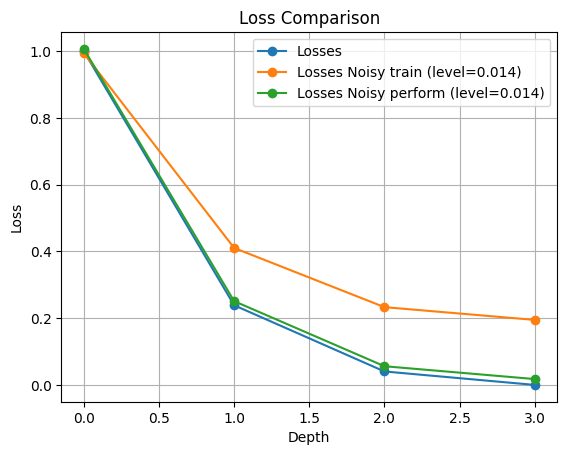

In [6]:
def process_noise_level(noises_level,device='qiskit_native'):
    V_dagger_V_noisy = __estimate_V_dagger_V(
        instance, ansatz_tree, loss_type=None, backend='qiskit-noisy', shots=0, 
        optimization_level=2, noise_level_two_qubit=noises_level, 
        noise_level_one_qubit=0.001, readout_error=0.007,device=device
    )
    
    q_noisy = __estimate_q(
        instance, ansatz_tree, backend='qiskit-noisy', shots=0, 
        optimization_level=2, noise_level_two_qubit=noises_level, 
        noise_level_one_qubit=0.001, readout_error=0.007,device=device
    )
    
    losses_noisy = []
    alphas_list = []
    losses_true = []
    
    for depth in tqdm(range(len(ansatz_tree)), desc=f"Noise {noises_level}"):
        Q, r = __reshape_to_Q_r(V_dagger_V_noisy[:depth+1, :depth+1], q_noisy[:depth+1])
        loss, alphas = solve_combination_parameters(Q, r, which_opt='ADAM')
        losses_noisy.append(loss)
        alphas_list.append(alphas)  # Store alphas for each depth
        losses_true+=[find_true_loss_function(alphas)]
    
    
    plt.plot(losses, "-o", label="Losses")
    plt.plot(losses_noisy, "-o", label=f"Losses Noisy train (level={noises_level})")
    plt.plot(losses_true, "-o", label=f"Losses Noisy perform (level={noises_level})")
    plt.legend()
    plt.xlabel("Depth")
    plt.ylabel("Loss")
    plt.title("Loss Comparison")
    plt.grid(True)
    plt.show()

for noises_level in [0.014]:
    process_noise_level(noises_level)
